In [24]:
from tree import Node, Production, ConstituencyTree
from cd_dynamic_program import compute_num_matching_subtrees_dp

import autograd.numpy as np
from autograd import grad
from joblib import Parallel, delayed
from random import seed, shuffle, sample, randrange
from scipy.spatial.distance import squareform

from GPy.kern.src.kern import Kern
from GPy.core import Param
from GPy.models import GPClassification

import seaborn as sb
import matplotlib.pyplot as plt

In [36]:
# Seeds and parameters
seed(42)
np.random.seed(42)

SMALL_NUM_SENTENCES = 100
LARGE_NUM_SENTENCES = 400

In [26]:
# Kernel class

class Custom_GPY(Kern):

    def __init__(self, input_dim, lamb, e, active_dims=None):
        super(Custom_GPY, self).__init__(input_dim, active_dims, 'custom')

        self.lamb = Param('lamb', lamb)
        self.lamb.constrain_positive()

        self.emb_scale = Param('emb_scale', e)
        self.emb_scale.constrain_positive()

        self.link_parameters(self.lamb, self.emb_scale)

    def K(self, X, X2):
        """
        Compute the full kernel matrix

        :param X: np.array
        :param X2: np.array
        :return: np.array
        """
        n = X.shape[0]

        if X2 is None: # Symmetric case

            # Compute the upper triangular values
            vec = np.empty(shape=n * (n - 1) // 2)
            k = 0
            for i in range(n - 1):
                for j in range(i + 1, n):
                    vec[k] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[j, 0], lamb=self.lamb)
                    k += 1

            # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
            CD = squareform(vec)

            # Compute the main diagonal
            CD_diag = np.empty(n)
            for i in range(n):
                CD_diag[i] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[i, 0], lamb=self.lamb)

            # Add the main diagonal to get the final Collins & Duffy matrix
            CD = CD + np.diag(CD_diag)

            # Calculate the embeddings matrix
            self.E_symm = self.emb_scale * np.array(np.matmul(X[:, 1:], X[:, 1:].T), dtype=np.float32)

            # Combine the C&D matrix with the embeddings matrix
            K = CD + self.E_symm

        else: # Non-symmetric case

            n2 = X2.shape[0]

            # Calculate the Collins & Duffy matrix
            CD = np.empty((n, n2))

            for i in range(n):
                for j in range(n2):
                    CD[i, j] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X2[j, 0], lamb=self.lamb)

            # Calculate the embeddings matrix
            self.E_asymm = self.emb_scale * np.array(np.matmul(X[:, 1:], X2[:, 1:].T), dtype=np.float32)

            # Combine the C&D matrix with the embeddings matrix
            K = CD + self.E_asymm

        return K

    def Kdiag(self, X):
        """
        Compute the main diagonal of the kernel matrix

        :param X: np.array
        :return: np.array (1-dim)
        """
        n = X.shape[0]
        CD_diag = np.empty(n)
        E_diag = np.empty(n)
        for i in range(n):
            CD_diag[i] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[i, 0], lamb=self.lamb)
            E_diag[i] = self.emb_scale * np.dot(X[i, 1:], X[i, 1:])

        return CD_diag + E_diag

    def update_gradients_full(self, dL_dK, X, X2):
        """
        Compute the gradient of the loss function w.r.t the hyperparameters.

        :param dL_dK: np.array
        :param X: np.array
        :param X2: np.array
        :return: None
        """
        n = X.shape[0]

        # Set up the derivative of the C&D dynamic program w.r.t lambda
        part_deriv = grad(compute_num_matching_subtrees_dp, 2)

        if X2 is None:

            # Compute the upper triangular values of the dK/dlambda
            vec = np.empty(shape=n * (n - 1) // 2)
            k = 0
            for i in range(n - 1):
                for j in range(i + 1, n):
                    vec[k] = part_deriv(X[i, 0], X[j, 0], self.lamb*1)
                    k += 1

            # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
            dlambda = squareform(vec)

            # Compute the main diagonal
            dlambda_diag = np.empty(n)
            for i in range(n):
                dlambda_diag[i] = part_deriv(X[i, 0], X[i, 0], self.lamb*1)

            # Add the main diagonal to get the final derivative
            dlambda = dlambda + np.diag(dlambda_diag)

            # Compute dL/demb_scale
            dE = self.E_symm / self.emb_scale
            self.emb_scale.gradient = np.sum(dE * dL_dK)

        else:

            n2 = X2.shape[0]

            # Evaluate the derivative at every element of the kernel matrix
            dlambda = np.empty((n, n2))
            for i in range(n):
                for j in range(n2):
                    dlambda[i, j] = part_deriv(X[i, 0], X2[j, 0], self.lamb*1)

            # Compute dL/demb_scale
            dE = self.E_asymm / self.emb_scale
            self.emb_scale.gradient = np.sum(dE * dL_dK)

        # Compute dL/dlambda
        self.lamb.gradient = np.sum(dlambda * dL_dK)
    
    def to_dict(self):
        
        input_dict = super()._save_to_input_dict()
        input_dict["class"] = "GPy.kern.CustomKernel"
        return input_dict

In [27]:
# Helper functions

def extract_sentences(data, sent_inds):
    """
    Extract the true parses, candidate parses and embeddings for the given sentences.

    :param data: list of np.arrays
    :param sent_inds: list of int
    :return: 3-tuple of lists
    """
    true_parses, parses, embeddings = data

    return [true_parses[ind] for ind in sent_inds], [parses[ind] for ind in sent_inds], [embeddings[ind] for ind in sent_inds]


def prepare_dataset(data, sent_inds):
    """
    Set up the data matrix and response vector from the parse trees and embeddings.

    :param data: list of np.arrays
    :param sent_inds: list of int
    :return: tuple of np.arrays
    """
    true_parses_ind, parses_ind, embeddings_ind = extract_sentences(data, sent_inds)

    # Compute the length of the dataset
    dataset_len = 0
    for cand_parse_arr in parses_ind:
        dataset_len += cand_parse_arr.shape[0] + 1  # +1 for the true parse

    # Initialize the response vector
    y = np.empty(shape=dataset_len)

    # Initialize the feature matrix
    embedding_length = embeddings_ind[0].shape[0] # ASSUMPTION: All embeddings have the same length
    X = np.empty(shape=(dataset_len, embedding_length + 1), dtype=object) # +1 for the trees

    ind = 0
    for sent_ind in range(len(true_parses_ind)):

        embedding = embeddings_ind[sent_ind]

        # True parse
        y[ind] = 1
        X[ind, 0] = true_parses_ind[sent_ind]
        X[ind, 1:] = embedding

        # Candidate parses
        num_cand_parses = parses_ind[sent_ind].shape[0]
        for cand_parse_ind in range(num_cand_parses):
            y[ind + cand_parse_ind + 1] = 0
            X[ind + cand_parse_ind + 1, 0] = parses_ind[sent_ind][cand_parse_ind]
            X[ind + cand_parse_ind + 1, 1:] = embedding # Embedding is the same for the candidates

        ind += num_cand_parses + 1

    return X, y


def fit_model(data, train_sent):
    """
    Fit a GPClassification model based on the train_sent

    :param data: list of np.arrays
    :param sent_inds: list of int
    :return: tuple of np.arrays
    """
    X_train, y_train = prepare_dataset(data=data, sent_inds=train_sent)
    
    kernel = Custom_GPY(input_dim=X_train.shape[1],lamb=0.5122493885645022, e=0.019017003926375585) # average values from optimized model on 50 observations
    return GPClassification(X=X_train, Y=y_train.reshape(-1, 1), kernel=kernel)
    
    # Additional idea: Save the model -> problem so far: Node Object is not JSON serializable, i.e. make the class json serializable and re-run everything
    # Also: the kernel here has an additional method "to_dict", which is essential for that
    # gp_model.save_model(f"gp_model_{len(train_sent)}", compress=False, save_data=False)

def convert_into_corr_mat(cov_mat):
    """
    Convert a covariance matrix into a correlation matrix
    
    :param sent_inds: np.array
    :return: np.array
    """
    n = cov_mat.shape[0]
    upper_triang = np.empty(shape=n * (n - 1) // 2)
    k = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            upper_triang[k] = cov_mat[i,j]/(np.sqrt(cov_mat[i,i])*np.sqrt(cov_mat[j,j]))
            k += 1

    # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
    corr = squareform(upper_triang)
    corr = corr + np.diag(np.ones(n))
    
    return corr

In [1]:
import numpy as np

from nltk.corpus import treebank
from nltk import Nonterminal, ChartParser
from nltk import induce_pcfg
from nltk.tree import Tree
from nltk.parse import pchart

from sentence_transformers import SentenceTransformer

from tree import Node, Production, ConstituencyTree

In [2]:
def build_grammar_from_treebank():
    """
    Builds a PCFG based on the files in the NLTK treebank

    :return: nltk.grammar
    """
    sentences = []
    gold_standards = []
    productions = []

    for item in treebank.fileids():

        tree_sent_pairs = zip(treebank.sents(item), treebank.parsed_sents(item))

        for sent, tree in tree_sent_pairs:  # iterate through all sentences and trees from each file

            if len(sent) < 15:  # Only take sentences of length < 15 to ensure different parses

                # Keep track of sentence
                sentences.append(sent)

                # Bring trees in CNF
                tree.collapse_unary(collapsePOS=True)  # Remove branches A-B-C into A-B+C
                tree.chomsky_normal_form()  # Remove A->(B,C,D) into A->B,C+D->D

                # Keep track of true tree
                gold_standards.append(tree)

                # Keep track of productions to produce the PCFG
                productions += tree.productions()

    S = Nonterminal("S")
    grammar = induce_pcfg(S, productions)

    return grammar, gold_standards, sentences

In [9]:
sentences = [
    ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mrs.', 'Barnum', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mr.', 'Barnum', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mr.', 'Vinken', 'is', 'president', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Apple', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'U.S.', 'publishing', 'group', '.'],
    ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'financial', 'company', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'good', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'investment', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'companies', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'officially', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'making', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'just', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'below', '9', '%', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '50', '%', '.']
]

In [5]:
def generate_parse_trees_and_embeddings():
    """
    Put the gold standard parse trees in an appropriate form and generate candidate parse trees and embeddings

    :return: 3-tuple of np.arrays
    """
    # Set up the grammar
    grammar, _, _ = build_grammar_from_treebank()

    # Set up fastest parser in NLTK (= beam search)
    parser = pchart.InsideChartParser(grammar, beam_size=2000)

    # Set up sentence embedder
    model = SentenceTransformer('paraphrase-distilroberta-base-v1')

    # Number of candidate trees
    c = 5

    # Initialize the lists
    num_sentences = len(sentences)

    true_parses = [] # it can't be known in advance how many true_parses there will be (bec. only the ones with at least 5 cand parses are considered)
    parses = []
    embeddings = []

    for sent_ind in range(num_sentences):

        #true_parse = gold_standards[sent_ind]
        
        for best_parse in parser.parse(sentences[sent_ind]):
            true_parse = Tree.convert(tree=best_parse)
            break
        
        
        cand_parses = []

        count = 0

        # Take the c worst parses
        for ind, parse in enumerate(reversed(list(parser.parse(sentences[sent_ind])))):  # Reversing the list very expensive, maybe can pop
            if count > (c - 1):
                break
            if parse != true_parse:
                cand_parses.append(Tree.convert(tree=parse)) # Convert probabilistic tree into tree
                count += 1

        if len(cand_parses) == c:  # Checks if there are 5 candidate parses (could be more flexible maybe)
            # TO-DO: make the following cells flexible enough to support different lengths of cands

            # Print the current sentence that is actually included into the dataset
            print(sentences[sent_ind])

            # True parses and embeddings
            true_parses.append(true_parse)
            embeddings.append(model.encode("".join(sentences[sent_ind])))

            # Candidate parses for the given observation
            parses.append(cand_parses)

    return true_parses, parses, embeddings

In [ ]:
# Version zum Vorladen

for item in treebank.fileids():
    
    tree_sent_pairs = zip(treebank.sents(item), treebank.parsed_sents(item))

    for sent, tree in tree_sent_pairs:  # iterate through all sentences and trees from each file
        if len(sent) < 15:  # Only take sentences of length < 15 to ensure different parses
            # Keep track of sentence
            sentences.append(sent)

            # Bring trees in CNF
            tree.collapse_unary(collapsePOS=True)  # Remove branches A-B-C into A-B+C
            tree.chomsky_normal_form()  # Remove A->(B,C,D) into A->B,C+D->D

            # Keep track of true tree
            gold_standards.append(tree)

            # Keep track of productions to produce the PCFG
            productions += tree.productions()

S = Nonterminal("S")
grammar = induce_pcfg(S, productions)

In [31]:
true_parses_test, parses_test, embeddings_test = generate_parse_trees_and_embeddings() 

['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mrs.', 'Barnum', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mr.', 'Barnum', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mr.', 'Vinken', 'is', 'president', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Apple', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'U.S.', 'publishing', 'group', '.']
['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'financial', 'company', '.']
['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.']
['The', 'good', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.']
['The', 'top', 'investment', 'f

In [32]:
for t_parse in true_parses_test:
    t_parse.pretty_print()

                                                 S                                                                   
       __________________________________________|______                                                              
      |                                              S|<VP-.>                                                        
      |                   ______________________________|__________________________________________________________   
      |                  VP                                                                                        | 
      |             _____|____________                                                                             |  
      |            |                NP-PRD                                                                         | 
      |            |      ____________|_________________                                                           |  
      |            |     |                          

In [ ]:
# Push through data structure

In [72]:
def set_up_pos_to_span_dict(tree):
    """
    Return a dictionary that maps the nltk positions of each node to the corresponding span

    :param tree: nltk.Tree
    :return: dict
    """
    # Set up position to span dictionary
    pos_to_span = {}

    # Initialize with pre terminals
    for ind in range(len(tree.leaves())):
        pos = tree.leaf_treeposition(ind)
        pos_to_span[pos] = None # Terminals don't have a span
        pos_to_span[pos[:(len(pos) - 1)]] = (ind, ind + 1) # Pre-terminal spans

    # Go through the rest of the tree bottom up to derive the correct span
    for pos in tree.treepositions(order="postorder"):

        subtree = tree[pos] # Extract the subtree at that position
        if not isinstance(subtree, str) and len(subtree.productions()[0].rhs()) > 1:  # excludes terminals (with str condition) and pre terminals

            left = pos + (0,)
            right = pos + (1,)

            if left in pos_to_span and right in pos_to_span:
                start = pos_to_span[left][0]
                end = pos_to_span[right][1]

                pos_to_span[pos] = (start, end)

    return pos_to_span


def transform_nltk_trees(trees):
    """
    Transform a list of nltk trees into ConstituencyTrees.

    :param trees: np.array of nltk trees
    :return: list of ConstituencyTrees
    """
    new_trees = np.empty(shape=len(trees), dtype=object)

    for ind, tree in enumerate(trees):

        pos_to_span = set_up_pos_to_span_dict(tree) # Extract the dictionary mapping nltk positions to spans

        prods = []
        for pos in tree.treepositions(order="postorder"): # Go through productions bottom-up

            subtree = tree[pos]

            if not isinstance(subtree, str): # excludes terminals

                prod = subtree.productions()[0] # to get the actual production

                # Transform into new production
                prod_new = Production(start=Node(symbol=str(prod.lhs()), pos=pos_to_span[pos]),
                                      end=[Node(symbol=str(symb), pos=pos_to_span[pos + (ind,)]) for ind, symb in enumerate(prod.rhs())])

                prods.append(prod_new)

        new_trees[ind] = ConstituencyTree(productions=prods)

    return new_trees

In [73]:
new_true_trees_test = transform_nltk_trees(true_parses_test)

new_cands_lists_test = np.empty(shape=len(true_parses_test), dtype=object)
for ind, cands in enumerate(parses_test):
    new_cands_lists_test[ind] = transform_nltk_trees(cands)

In [28]:
# Load the data (assuming they were already generated - run save_model in data_generator.py first)
true_parses = np.load("true_parses.npy", allow_pickle=True)
cand_parses = np.load("cand_parses.npy", allow_pickle=True)
embeddings = np.load("embeddings.npy", allow_pickle=True)

In [29]:
# Adjust the number of sentences used
small_data = [true_parses[:SMALL_NUM_SENTENCES], cand_parses[:SMALL_NUM_SENTENCES], embeddings[:SMALL_NUM_SENTENCES]]
large_data = [true_parses[:LARGE_NUM_SENTENCES], cand_parses[:LARGE_NUM_SENTENCES], embeddings[:LARGE_NUM_SENTENCES]]

num_cands = small_data[1][0].shape[0] # Small and big dataset both have same constant number of candidate parse trees

In [30]:
# General idea for splitting: Make sure that the test set of the small data set is a subset of the test set of the large data set

# Sentences of small data set
small_sent = list(range(SMALL_NUM_SENTENCES))

# Take 1/2 of the data set randomly as the training set; the other half as test set
small_train_sent = sample(small_sent, k=int(len(small_sent)/2))
test_sent = [ind for ind in small_sent if ind not in small_train_sent]

# Exclude the sentences in small_test_sent from the large_sent before sampling the training set
large_sent = [sent for sent in list(range(LARGE_NUM_SENTENCES)) if sent not in test_sent]

# Sample again 1/2 of the total data points as training set
large_train_sent = sample(large_sent, k=int(len(large_sent)/2))

In [ ]:
### NEW

In [58]:
seed(42)
# General idea for splitting: Make sure that the test set of the small data set is a subset of the test set of the large data set

# Sentences of small data set
small_sent = list(range(SMALL_NUM_SENTENCES))

small_sent.remove(0)
small_sent.remove(4)

print(small_sent)

# Take 1/2 of the data set randomly as the training set; the other half as test set
small_train_sent = sample(small_sent, k=int(100/2))

# test_sent = [ind for ind in small_sent if ind not in small_train_sent]
test_sent = [0, 4]

# Exclude the sentences in small_test_sent from the large_sent before sampling the training set
large_sent = [sent for sent in list(range(LARGE_NUM_SENTENCES)) if sent not in test_sent]

# Sample again 1/2 of the total data points as training set
large_train_sent = sample(large_sent, k=int(len(large_sent)/2))

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [74]:
#new_parses_test, new_embeddings_test = np.array(parses_test, dtype=object), np.array(embeddings_test, dtype=object)
new_embeddings_test = np.array(embeddings_test, dtype=object)

In [60]:
#new_true_parses = np.empty(len(true_parses_test), dtype=object)
#for ind, true_parse_test in enumerate(true_parses_test):
#    new_true_parses[ind] = true_parse_test

In [75]:
data_test = [new_true_trees_test, new_cands_lists_test, new_embeddings_test]

In [76]:
X_test, y_test = prepare_dataset(data=data_test, sent_inds=list(range(len(true_parses_test))))

In [77]:
type(X_test[0,0])

tree.ConstituencyTree

In [47]:
# Generate the test set for evaluating the covariance matrix
X_test, y_test = prepare_dataset(data=small_data, sent_inds=test_sent)

AttributeError: 'list' object has no attribute 'shape'

In [63]:
small_model = fit_model(data=small_data, train_sent=small_train_sent)

 c:\users\flori\anaconda3\envs\mt\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [64]:
large_model = fit_model(data=large_data, train_sent=large_train_sent)

 c:\users\flori\anaconda3\envs\mt\lib\site-packages\autograd\tracer.py:14: UserWarning:Output seems independent of input.


In [78]:
post_mu_small, post_var_small = small_model._raw_predict(X_test, full_cov=True)
post_mu_large, post_var_large = large_model._raw_predict(X_test, full_cov=True)

In [ ]:
# This does not help for visualization of the cov matrixes, but was an idea that we talked about
new_post_var_small = post_var_small.copy()
new_post_var_large = post_var_large.copy()
np.fill_diagonal(new_post_var_small, 0)
np.fill_diagonal(new_post_var_large, 0)

In [79]:
# Convert into correlation matrix
post_cor_small = convert_into_corr_mat(post_var_small)
post_cor_large = convert_into_corr_mat(post_var_large)

<AxesSubplot:>

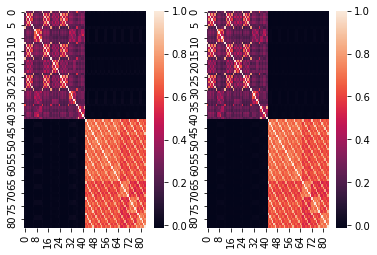

In [80]:
# Noch etwas breiter ziehen, dass es schöner aussieht

# All test samples -> Conclusion: Barely any correlations between the trees overall

fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small, ax=ax[0])
sb.heatmap(post_cor_large, ax=ax[1])

<AxesSubplot:>

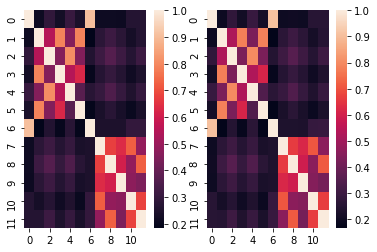

In [81]:
# Small amount of samples -> Conclusion: Correlations only within one reranking set

fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small[:12,:12], ax=ax[0])
sb.heatmap(post_cor_large[:12,:12], ax=ax[1])

<AxesSubplot:>

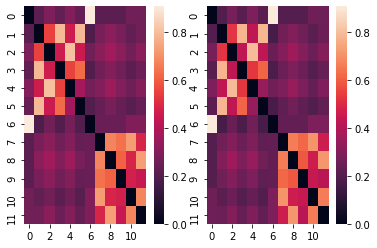

In [86]:
# Small amount of samples without main diagonal

post_cor_small_no_diag = post_cor_small.copy()
post_cor_large_no_diag = post_cor_large.copy()

np.fill_diagonal(post_cor_small_no_diag, 0)
np.fill_diagonal(post_cor_large_no_diag, 0)

fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small_no_diag[:12,:12], ax=ax[0])
sb.heatmap(post_cor_large_no_diag[:12,:12], ax=ax[1])

<AxesSubplot:>

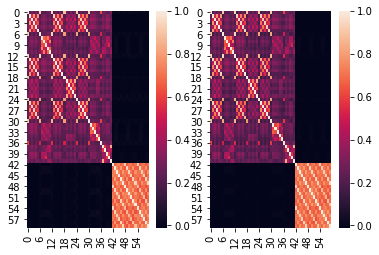

In [82]:
# Medium number of samples -> Conclusion: ?

fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small[:60,:60], ax=ax[0])
sb.heatmap(post_cor_large[:60,:60], ax=ax[1])

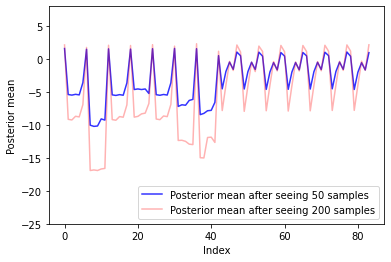

In [83]:
# Why is the performance still better though? - Answer lies in the mean function

plt.plot(post_mu_small, 'b-', alpha=0.8)
plt.plot(post_mu_large, 'r-', alpha=0.3)
plt.ylim([-25, 8])
plt.ylabel("Posterior mean")
plt.xlabel("Index")
plt.legend(["Posterior mean after seeing 50 samples", "Posterior mean after seeing 200 samples"], loc="lower right")

# Histogram?

# Ratio von rot zu blau für jeden Index berechnen und dann mean bilden